In [1]:
# Systeme interaction
from platform import python_version
from os import listdir, rename
from os.path import isfile, join
import os
import shutil
import sys

# Data traitment
import numpy as np
import pandas as pd
import librosa
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler

# Data visualisation
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Machine learning
import sklearn
import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

# Serialisation
import joblib

# S3
import boto3
from boto3.s3.transfer import S3Transfer

datasets = [
    ("savee", "ejlok1/surrey-audiovisual-expressed-emotion-savee"),
    ("ravdess", "uwrfkaggler/ravdess-emotional-speech-audio"),
    ("tess", "ejlok1/toronto-emotional-speech-set-tess"),
    ("cremad", "ejlok1/cremad")
]




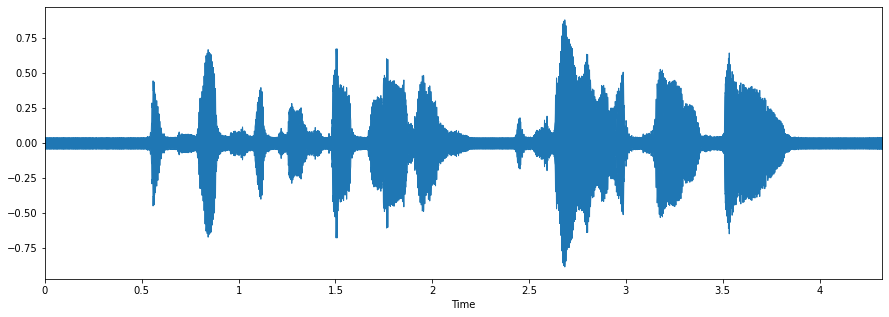

In [2]:
fname = './input/SAVEE/ALL/DC_f11.wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

ipd.Audio(fname)

In [3]:
dataframe_savee = pd.DataFrame(columns=['source', 'path', 'label'])

def label(audio):
    if audio[-8:-6] == '_a':
        return 'male_angry'
    elif audio[-8:-6] == '_d':
        return 'male_disgust'
    elif audio[-8:-6] == '_f':
        return 'male_fear'
    elif audio[-8:-6] == '_h':
        return 'male_happy'
    elif audio[-8:-6] == '_n':
        return 'male_neutral'
    elif audio[-8:-6] == 'sa':
        return 'male_sad'
    elif audio[-8:-6] == 'su':
        return 'male_surprise'
    else:
        return 'male_error'

sys.stdout.write("savee insertion in progress...")
sys.stdout.flush()
path = "./input/SAVEE/ALL"
audios = [f for f in listdir(path) if isfile(join(path, f))]
for audio in audios:
    dataframe_savee = dataframe_savee.append({
        'source': 'SAVEE',
        'path': "./input/SAVEE/ALL/" + audio,
        'label': label(audio)
    }, ignore_index=True)
sys.stdout.write("\nsavee insertion done.")

savee insertion in progress...
savee insertion done.

In [4]:
dataframe_savee.label.value_counts()

male_neutral     120
male_disgust      60
male_angry        60
male_fear         60
male_happy        60
male_surprise     60
male_sad          60
Name: label, dtype: int64

In [5]:
dataframe_ravdess = pd.DataFrame(columns=['source', 'path', 'label'])

def sex(part):
    if int(part) % 2 == 0:
        return "female"
    else:
        return "male"

def emotion(part):
    if part == '05':
        return 'angry'
    elif part == '07':
        return 'disgust'
    elif part == '06':
        return 'fear'
    elif part == '03':
        return 'happy'
    elif part == '01':
        return 'neutral'
    elif part == '02':
        return 'neutral'
    elif part == '04':
        return 'sad'
    elif part == '08':
        return 'surprise'
    else:
        return 'error'


def label(audio):
    parts = audio.split(".")[0].split("-")
    return "{sex}_{emotion}".format(sex=sex(parts[6]), emotion=emotion(parts[2]))

sys.stdout.write("ravdess insertion in progress...")
sys.stdout.flush()
actors = [f for f in listdir("./input/RAVDESS") if f[-4:] != ".zip"]
for actor in actors:
    path = "./input/RAVDESS/{actor}/".format(actor=actor)
    audios = [f for f in listdir(path) if isfile(join(path, f))]
    for audio in audios:
        dataframe_ravdess = dataframe_ravdess.append({
            'source': 'RAVDESS',
            'path': path + audio,
            'label': label(audio)
        }, ignore_index=True)
sys.stdout.write("\nravdess insertion done.")

ravdess insertion in progress...
ravdess insertion done.

In [6]:
dataframe_ravdess.label.value_counts()


female_neutral     144
male_neutral       144
male_surprise       96
female_angry        96
female_sad          96
male_happy          96
female_disgust      96
male_disgust        96
female_fear         96
male_angry          96
female_surprise     96
female_happy        96
male_fear           96
male_sad            96
Name: label, dtype: int64

In [7]:
dataframe_tess = pd.DataFrame(columns=['source', 'path', 'label'])

def label(folder):
    if folder == 'OAF_angry' or folder == 'YAF_angry':
        return 'female_angry'
    elif folder == 'OAF_disgust' or folder == 'YAF_disgust':
        return 'female_disgust'
    elif folder == 'OAF_Fear' or folder == 'YAF_fear':
        return 'female_fear'
    elif folder == 'OAF_happy' or folder == 'YAF_happy':
        return 'female_happy'
    elif folder == 'OAF_neutral' or folder == 'YAF_neutral':
        return 'female_neutral'
    elif folder == 'OAF_Pleasant_surprise' or folder == 'YAF_pleasant_surprised':
        return 'female_surprise'
    elif folder == 'OAF_Sad' or folder == 'YAF_sad':
        return 'female_sad'
    else:
        return 'female_error'

sys.stdout.write("tess insertion in progress...")
sys.stdout.flush()
folders = [f for f in listdir("./input/TESS/TESS Toronto emotional speech set data") if f != "TESS Toronto emotional speech set data"]
for folder in folders:
    path = "./input/TESS/TESS Toronto emotional speech set data/{folder}/".format(folder=folder)
    folder_type = type(folder)
    audios = [f for f in listdir(path) if isfile(join(path, f))]
    for audio in audios:
        dataframe_tess = dataframe_tess.append({
            'source': 'TESS',
            'path': path + audio,
            'label': label(folder)
        }, ignore_index=True)
sys.stdout.write("\ntess insertion done.")

tess insertion in progress...
tess insertion done.

In [8]:
dataframe_tess.label.value_counts()

female_neutral     400
female_fear        400
female_happy       400
female_angry       400
female_sad         400
female_disgust     400
female_surprise    400
Name: label, dtype: int64

In [9]:
dataframe_cremad = pd.DataFrame(columns=['source', 'path', 'label'])

def sexe(part):
    female = [1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1012, 1013, 1018, 1020, 1021, 1024, 1025, 1028, 1029,
              1030, 1037, 1043, 1046, 1047, 1049,
              1052, 1053, 1054, 1055, 1056, 1058, 1060, 1061, 1063, 1072, 1073, 1074, 1075, 1076, 1078, 1079, 1082,
              1084, 1089, 1091]
    if int(part) in female:
        return 'female'
    else:
        return 'male'

def emotion(part):
    if part == 'SAD':
        return 'sad'
    elif part == 'ANG':
        return 'angry'
    elif part == 'DIS':
        return 'disgust'
    elif part == 'FEA':
        return 'fear'
    elif part == 'HAP':
        return 'happy'
    elif part == 'NEU':
        return 'neutral'
    else:
        return 'error'

def label(audio):
    parts = audio.split('.')[0].split('_')
    return "{sexe}_{emotion}".format(sexe=sexe(parts[0]), emotion=emotion(parts[2]))

sys.stdout.write("cremad insertion in progress...")
sys.stdout.flush()
path = "./input/CREMA-D/AudioWAV"
audios = [f for f in listdir(path) if isfile(join(path, f))]
for audio in audios:
    dataframe_cremad = dataframe_cremad.append({
        'source': 'CREMA-D',
        'path': "./input/CREMA-D/AudioWAV/" + audio,
        'label': label(audio)
    }, ignore_index=True)
sys.stdout.write("\ncremad insertion done.")

cremad insertion in progress...
cremad insertion done.

In [10]:
dataframe_cremad.label.value_counts()

male_disgust      671
male_angry        671
male_fear         671
male_happy        671
male_sad          671
female_happy      600
female_angry      600
female_sad        600
female_disgust    600
female_fear       600
male_neutral      575
female_neutral    512
Name: label, dtype: int64

In [11]:
dataframe = pd.concat([dataframe_savee, dataframe_ravdess, dataframe_tess, dataframe_cremad])

In [12]:
dataframe.head(10)

,source,path,label
0,SAVEE,./input/SAVEE/ALL/DC_d13.wav,male_disgust
1,SAVEE,./input/SAVEE/ALL/KL_h03.wav,male_happy
2,SAVEE,./input/SAVEE/ALL/KL_n15.wav,male_neutral
3,SAVEE,./input/SAVEE/ALL/DC_f07.wav,male_fear
4,SAVEE,./input/SAVEE/ALL/JE_h03.wav,male_happy
5,SAVEE,./input/SAVEE/ALL/KL_f04.wav,male_fear
6,SAVEE,./input/SAVEE/ALL/JE_n15.wav,male_neutral
7,SAVEE,./input/SAVEE/ALL/JK_su06.wav,male_surprise
8,SAVEE,./input/SAVEE/ALL/JK_h07.wav,male_happy
9,SAVEE,./input/SAVEE/ALL/KL_n14.wav,male_neutral


In [13]:
len(dataframe)

12162

In [14]:
dataframe.label.value_counts()

female_happy       1096
female_angry       1096
female_sad         1096
female_disgust     1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_fear           827
male_happy          827
male_sad            827
male_disgust        827
male_angry          827
female_surprise     496
male_surprise       156
Name: label, dtype: int64

In [15]:
dataframe[['sexe', 'emotion']] = dataframe.label.str.split('_', expand=True)

In [16]:
dataframe.sexe.value_counts()

female    7032
male      5130
Name: sexe, dtype: int64

In [17]:
dataframe.emotion.value_counts()

disgust     1923
fear        1923
angry       1923
sad         1923
happy       1923
neutral     1895
surprise     652
Name: emotion, dtype: int64

In [18]:
def mfcc(paths):
    features = pd.DataFrame(columns=['feature'])
    counter = 0
    
    for index, path in enumerate(paths):
        X, sample_rate = librosa.load(path, 
                                      res_type='kaiser_fast',
                                      duration=2.5,
                                      sr=44100,
                                      offset=0.5
                                     )
        sample_rate = np.array(sample_rate)

        # mean as the feature. Could do min and max etc as well. 
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        features.loc[counter] = [mfccs]
        counter=counter+1   

    return features

In [19]:
mfcc_transformer = FunctionTransformer(mfcc)

In [20]:
def explode_array(data):
    return pd.DataFrame(data['feature'].values.tolist())

In [21]:
explode_array_transformer = FunctionTransformer(explode_array)

In [22]:
## Sachant qu'on coupe l'audio à 2.5sec, on peut avoir que maximum 216 colonnes
def complete_column(data):
    n_col = len(data.columns)
    return pd.concat([data, pd.DataFrame(columns=range(n_col, 216))])

In [23]:
complete_column_transformer = FunctionTransformer(complete_column)

In [24]:
noNan_transformer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [25]:
standart_transformer = StandardScaler()

In [26]:
def expand_dims(data):
    return np.expand_dims(data, axis=2)

In [27]:
expand_transformer = FunctionTransformer(expand_dims)

In [28]:
data_train, data_test, label_train, label_test = train_test_split(dataframe.path, 
                                                                  dataframe.label, 
                                                                  test_size=0.20, 
                                                                  shuffle=True, 
                                                                  random_state=42)

## On realise le mfcc en amont car couteux lors de la recherche des hyperparamètres
data_train_hyperparameter = mfcc(data_train)

In [29]:
data_train.head(5)

5566         ./input/CREMA-D/AudioWAV/1056_IWL_FEA_XX.wav
867          ./input/CREMA-D/AudioWAV/1018_MTI_ANG_XX.wav
2227    ./input/TESS/TESS Toronto emotional speech set...
537          ./input/CREMA-D/AudioWAV/1074_IEO_NEU_XX.wav
708     ./input/TESS/TESS Toronto emotional speech set...
Name: path, dtype: object

In [30]:
data_train_hyperparameter.head(5)

,feature
0,"[-15.938234, -16.181871, -15.108466, -15.48746..."
1,"[-14.397645, -13.691896, -12.738484, -14.27865..."
2,"[-17.758554, -20.753927, -31.188519, -30.74416..."
3,"[-20.464037, -18.943378, -17.680613, -17.73756..."
4,"[-12.822536, -16.789309, -32.362755, -31.97537..."


In [31]:
label_train[:5]

5566       female_fear
867       female_angry
2227        female_sad
537     female_neutral
708        female_fear
Name: label, dtype: object

In [32]:
def generate_model(dropout=0.25, optimizer='adagrad', kernel_initializer='glorot_uniform'):
    model = Sequential()
    model.add(Conv1D(256, 8, padding='same',input_shape=(216, 1)))
    model.add(Activation("relu"))
    model.add(Conv1D(256, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Conv1D(128, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Conv1D(128, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Conv1D(128, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(64, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Conv1D(64, 8, padding='same',kernel_initializer=kernel_initializer))
    model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(14))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

generate_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [33]:
classifier = KerasClassifier(build_fn=generate_model, epochs=5)

def create_pipeline(shipping=False):
    pipes = []
    if shipping:
        pipes.append(('mfcc', mfcc_transformer)) # cost too much time during the training phase
    pipes.append(('explode', explode_array_transformer))
    pipes.append(('complete', complete_column_transformer))
    pipes.append(('noNan', noNan_transformer))
    pipes.append(('standart', standart_transformer))
    pipes.append(('expand_dims', expand_transformer))
    pipes.append(('my_classifier', classifier))
    return Pipeline(pipes)

pipeline = create_pipeline()
pipeline_shipping = create_pipeline(shipping = True)

In [34]:
param_grid = {
    'my_classifier__dropout':[0.1,0.3],
    #'my_classifier__optimizer':['rmsprop','adam','adagrad'],
    #'my_classifier__kernel_initializer':['glorot_uniform','normal','uniform']
}

In [35]:
grid = GridSearchCV(pipeline, param_grid, cv=3) 

In [36]:
grid.fit(data_train_hyperparameter,label_train) 

Epoch 1/5
203/203 [==============================] - 32s 157ms/step - loss: 2.1558 - accuracy: 0.2507
Epoch 2/5
203/203 [==============================] - 34s 165ms/step - loss: 1.9004 - accuracy: 0.3366
Epoch 3/5
203/203 [==============================] - 35s 171ms/step - loss: 1.8014 - accuracy: 0.3700
Epoch 4/5
203/203 [==============================] - 32s 156ms/step - loss: 1.7397 - accuracy: 0.3984
Epoch 5/5
102/102 [==============================] - 6s 61ms/step - loss: 1.7655 - accuracy: 0.3925
Epoch 1/5
203/203 [==============================] - 33s 162ms/step - loss: 2.1951 - accuracy: 0.2475
Epoch 2/5
203/203 [==============================] - 35s 173ms/step - loss: 1.9262 - accuracy: 0.3347
Epoch 3/5
203/203 [==============================] - 34s 170ms/step - loss: 1.8048 - accuracy: 0.3760
Epoch 4/5
203/203 [==============================] - 33s 161ms/step - loss: 1.7267 - accuracy: 0.4060
Epoch 5/5
102/102 [==============================] - 6s 60ms/step - loss: 1.7474 - a

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('explode',
                                        FunctionTransformer(func=<function explode_array at 0x7f3889ac8830>)),
                                       ('complete',
                                        FunctionTransformer(func=<function complete_column at 0x7f3889ac88c0>)),
                                       ('noNan', SimpleImputer()),
                                       ('standart', StandardScaler()),
                                       ('expand_dims',
                                        FunctionTransformer(func=<function expand_dims at 0x7f3889b3a170>)),
                                       ('my_classifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3889b5a350>)]),
             param_grid={'my_classifier__dropout': [0.1, 0.3]})

In [37]:
grid.best_params_

{'my_classifier__dropout': 0.1}

In [39]:
pipeline_shipping.set_params(my_classifier__dropout=0.1, my_classifier__optimizer="adam",my_classifier__epochs=50)

Pipeline(steps=[('mfcc',
                 FunctionTransformer(func=<function mfcc at 0x7f3889ac8ef0>)),
                ('explode',
                 FunctionTransformer(func=<function explode_array at 0x7f3889ac8830>)),
                ('complete',
                 FunctionTransformer(func=<function complete_column at 0x7f3889ac88c0>)),
                ('noNan', SimpleImputer()), ('standart', StandardScaler()),
                ('expand_dims',
                 FunctionTransformer(func=<function expand_dims at 0x7f3889b3a170>)),
                ('my_classifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3889b5a350>)])

In [40]:
pipeline_shipping.fit(data_train, label_train)

Epoch 1/50
305/305 [==============================] - 50s 163ms/step - loss: 2.2033 - accuracy: 0.2152
Epoch 2/50
305/305 [==============================] - 49s 159ms/step - loss: 1.9940 - accuracy: 0.2824
Epoch 3/50
305/305 [==============================] - 50s 165ms/step - loss: 1.8786 - accuracy: 0.3333
Epoch 4/50
305/305 [==============================] - 53s 173ms/step - loss: 1.7748 - accuracy: 0.3659
Epoch 5/50
305/305 [==============================] - 53s 172ms/step - loss: 1.7056 - accuracy: 0.4000
Epoch 6/50
305/305 [==============================] - 49s 162ms/step - loss: 1.6750 - accuracy: 0.4062
Epoch 7/50
305/305 [==============================] - 51s 166ms/step - loss: 1.6349 - accuracy: 0.4128
Epoch 8/50
305/305 [==============================] - 50s 163ms/step - loss: 1.6157 - accuracy: 0.4318
Epoch 9/50
305/305 [==============================] - 49s 161ms/step - loss: 1.5876 - accuracy: 0.4317
Epoch 10/50
305/305 [==============================] - 54s 176ms/step - l

Pipeline(steps=[('mfcc',
                 FunctionTransformer(func=<function mfcc at 0x7f3889ac8ef0>)),
                ('explode',
                 FunctionTransformer(func=<function explode_array at 0x7f3889ac8830>)),
                ('complete',
                 FunctionTransformer(func=<function complete_column at 0x7f3889ac88c0>)),
                ('noNan', SimpleImputer()), ('standart', StandardScaler()),
                ('expand_dims',
                 FunctionTransformer(func=<function expand_dims at 0x7f3889b3a170>)),
                ('my_classifier',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3889b5a350>)])

In [41]:
data_train

5566         ./input/CREMA-D/AudioWAV/1056_IWL_FEA_XX.wav
867          ./input/CREMA-D/AudioWAV/1018_MTI_ANG_XX.wav
2227    ./input/TESS/TESS Toronto emotional speech set...
537          ./input/CREMA-D/AudioWAV/1074_IEO_NEU_XX.wav
708     ./input/TESS/TESS Toronto emotional speech set...
                              ...                        
7244         ./input/CREMA-D/AudioWAV/1017_IWW_NEU_XX.wav
471          ./input/CREMA-D/AudioWAV/1036_ITH_SAD_XX.wav
670          ./input/CREMA-D/AudioWAV/1013_WSI_SAD_XX.wav
380     ./input/RAVDESS/Actor_11/03-01-04-02-01-01-11.wav
2550         ./input/CREMA-D/AudioWAV/1038_ITH_FEA_XX.wav
Name: path, Length: 9729, dtype: object

In [42]:
prediction = pipeline_shipping.predict(data_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [43]:
pipeline_shipping.score(data_test, label_test)

77/77 [==============================] - 5s 60ms/step - loss: 3.0170 - accuracy: 0.4266


0.4266337752342224

In [44]:
comparison = pd.DataFrame({'true_values': list(label_test)}).join(pd.DataFrame({'predicted_values':prediction}))

In [45]:
comparison.head(20)

,true_values,predicted_values
0,male_neutral,male_happy
1,female_disgust,female_disgust
2,female_disgust,male_angry
3,male_happy,male_happy
4,female_disgust,male_disgust
5,female_neutral,male_sad
6,female_happy,female_neutral
7,female_sad,female_neutral
8,female_neutral,female_fear
9,female_surprise,female_neutral


In [46]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

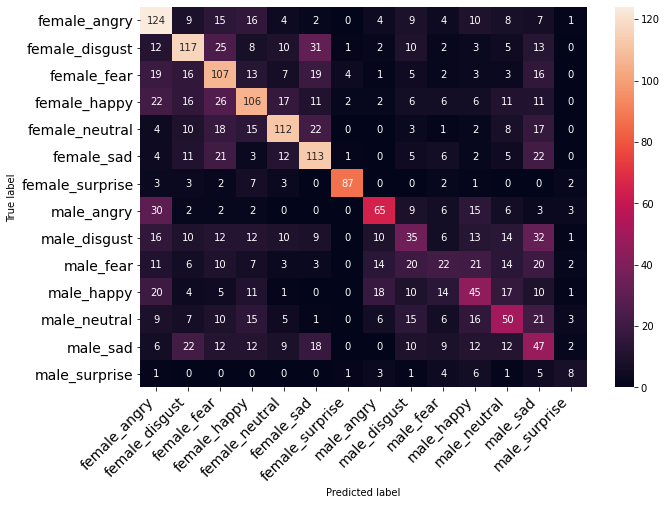

In [47]:
classes = comparison.true_values.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(comparison.true_values, comparison.predicted_values)
print_confusion_matrix(c, class_names = classes)

In [48]:
livrable = {
    "schema": "path that lead to a .wav files",
    "labels": list(dataframe.label.unique()),
    "pipeline": pipeline_shipping
}

name = 'livrable-00001'